# Extreme Learning Machines
---

## Contents
---

+ Theoretical Introduction
+ CODE  
 - Model Creation  
 - Model Training  
 - Forecasting  
 - Model evaluation  
 - Conclusion  
+ Conclusion


## Theoretical lntroduction
---
Extreme Learning Machines are an important emergent machine learning techniques. The main aspects of these techniques is that they **do not need a learning process** to calculate the parameters of the models.  

Essentially, an EML is a Single-Layer Feed-Forward Neural Network [(SLFN)](https://en.wikipedia.org/wiki/Feedforward_neural_network). ELM theory show that the value of the weight of this hidden layer need not to be tuned, and be therefore independent of the training data.  

<img src='./Images/single_hidden.png'>

The [**universal approximation property**](https://en.wikipedia.org/wiki/Universal_approximation_theorem) implies that an EML can solve any regression problem with a desired accuracy, if it has enough hidden neurons and training data to learn parameters for all the hidden neurons.  

EMLs also benefit from model structure and regularizaition, which reduces the negatives effects of ranfom initialization and overfitting.  

Given a set of N training samples ```(x, t)```. A SLFN with L hidden neuron outputs are:
<img src='./Images/eml_1.png'>

The relation between the target and the inputs and outputs of the network are:
<img src='./Images/eml_2.png'>

The hidden neurons are tranforming the input data into a different representation in two steps. First, the data is projected into the hidden layer through the weights and biases of the input layer, and then applying to the result of that a non-linear activation function.  

Practically, ELMs are solved as common Neural Networks in their matrix form. The matrix form is represented here:
<img src='./Images/eml_3.png'>

And here is where the important part of this method comes. Given that T is the target we want to reach, a unique solution a the system with least squared error cam be found using **Moore-Penrose genealized inverse**. Therefore, we can compute in one sigle operation the values of the weights of the hidden layer that will result in the solution with the least error to predict the target T. 
<img src='./Images/eml_4.png'>

This pseudoinverse in calculated used the [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition)  

In [this article](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7140733) there is a well documented description in detail about how EML works, and a package for High-Performance Toolbox for EML and omplementation in MAtlab and Python.

## Code
---

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 14 14:13:37 2018
@author: pablorr10
EML Algorithm to train an NN with a single hidden layer
"""

import time
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

np.random.seed(2018)

(475, 22)


<function matplotlib.pyplot.show>

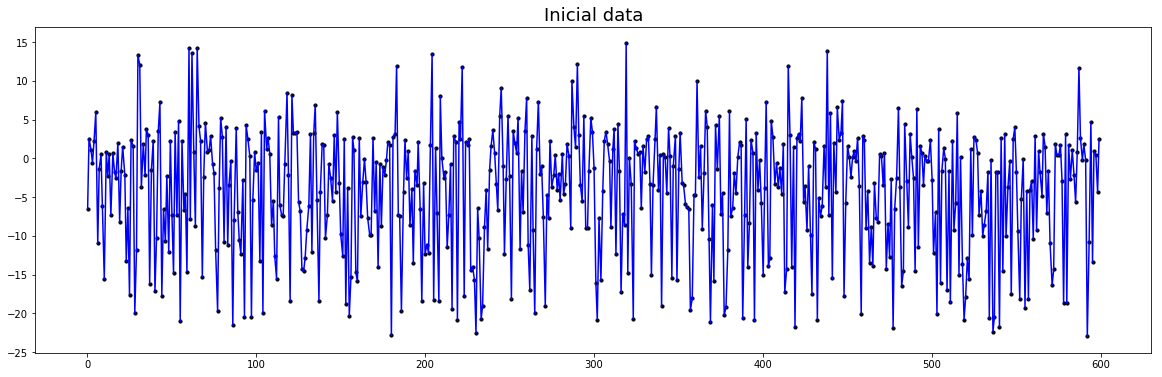

In [4]:
##############################################################################
# IMPORT DATA AND WINDOWS
##############################################################################
path_to_data = './windows_ts.h5'

dataset = pd.read_hdf(path_to_data, 'dataset')
trainset = pd.read_hdf(path_to_data, 'trainset')
testset = pd.read_hdf(path_to_data, 'testset')

train_windows = pd.read_hdf(path_to_data, 'train_windows')
test_windows = pd.read_hdf(path_to_data, 'test_windows')
train_windows_eml_inc = pd.read_hdf(path_to_data, 'train_windows_y_inc')
test_windows_eml_inc = pd.read_hdf(path_to_data, 'test_windows_y_inc')

# Bring here the window used
w = 5
print(train_windows.shape)

plt.figure(figsize=(20,6))
plt.title('Inicial data', fontsize=18)
plt.plot(dataset['t'], dataset['y'], 'b-')
plt.scatter(dataset['t'], dataset['y'], color='black', s=10)
plt.show

In [4]:
##############################################################################
# CREATION OF THE NETWORK
##############################################################################        
class Network(object):

    def __init__(self, input_dim, hidden_dim=10, output_dim=1):
        '''
        Neural Network object 
        '''
        self.N = input_dim
        self.M = hidden_dim
        self.O = output_dim
        
        self.W1 = np.matrix(np.random.rand(self.N, self.M))
        self.W2 = np.matrix(np.random.rand(self.M, self.O))
        
        self.U = 0
        self.V = 0
        self.S = 0
        self.H = 0
        self.alpha = 0 # for regularization
        
    # Helper function
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-0.1 * x)) - 0.5
    
    def predict(self, x):
        '''
        Forward pass to calculate the ouput
        '''
        x = np.matrix(x)
        y = self.sigmoid(x @ self.W1) @ self.W2
        return y
    
    def train(self, x, y):
        '''
        Compute W2 that lead to minimal LS
        '''
        X = np.matrix(x)
        Y = np.matrix(y)
        self.H = np.matrix(self.sigmoid(X @ self.W1))
        H = cp.deepcopy(self.H)
        
        self.svd(H)
        iH = np.matrix(self.V) @ np.matrix(np.diag(self.S)).I @ np.matrix(self.U).T

        self.W2 = iH * Y
        print('W2 values updated..')
        #return np.linalg.norm(H @ self.W2 - Y)
        return H @ self.W2 - Y
    
    def svd(self, h):
        '''
        Compute the Singular Value Decomposition of a matrix H
        '''
        H = np.matrix(h)
        self.U, self.S, Vt = np.linalg.svd(H, full_matrices=False)
        self.V = np.matrix(Vt).T
        print('SVD computed.. calculating Pseudoinverse..')
        return np.matrix(self.U), np.matrix(self.S), np.matrix(self.V)


    def update():
        '''
        Include new samples - Increment SVD
        '''
        pass
    
    def downdate():
        '''
        Remove old samples - Decrement SVD
        '''
        pass

In [6]:
##############################################################################
# TRAIN THE NETWORK AND PREDICT - Without previous y
############################################################################## 
in_dim = train_windows.shape[1] - 1
NN = Network(input_dim=in_dim, hidden_dim=20, output_dim=1)
t0 = time.time()
eml_residuals = NN.train(x = train_windows.iloc[:,:-1], 
                     y = train_windows.iloc[:,-1].values.reshape(-1,1))
tF = time.time()

# U,S,V = NN.svd(NN.H)


fit = NN.predict(train_windows.iloc[:,:-1])
predictions = NN.predict(test_windows.iloc[:,:-1])

'''
eml_fit = scaler.inverse_transform(fit)
eml_pred = scaler.inverse_transform(predictions)
'''

eml_fit = cp.deepcopy(fit)
eml_pred = cp.deepcopy(predictions)

eml_residuals = eml_pred - testset.iloc[w:, -1].values.reshape(-1,1)
eml_rmse = np.sqrt(np.sum(np.power(eml_residuals,2)) / len(eml_residuals))
print('RMSE = %.2f' % eml_rmse)
print('Time to train %.2f' % (tF - t0))

SVD computed.. calculating Pseudoinverse..
W2 values updated..
RMSE = 3.77
Time to train 0.12


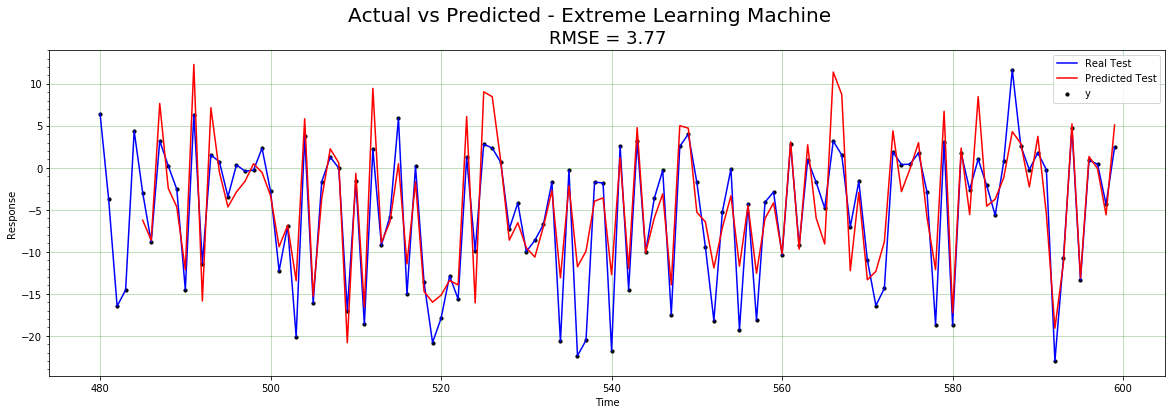

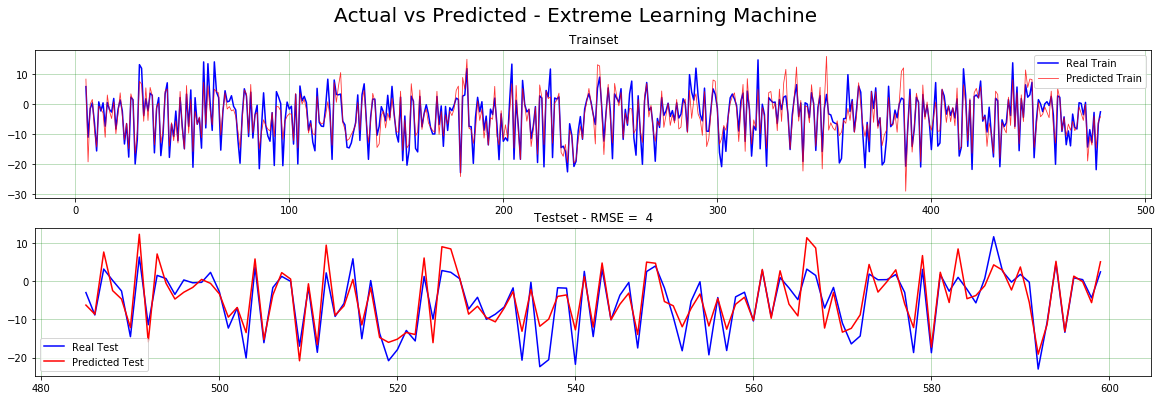

In [9]:
eml_y_fit = eml_fit # This is steps is in case y_fit = unscale(fit)
eml_y_pred = eml_pred # In casa y_pred = unscale(pred)

# Plot predictions
f, ax = plt.subplots(1, figsize=(20,6))
plt.suptitle('Actual vs Predicted - Extreme Learning Machine' , fontsize=20)
plt.title('RMSE = %.2f' % eml_rmse, fontsize = 18)
plt.grid(color='green', linewidth=0.5, alpha=0.5)

plt.scatter(testset.index, testset.y, color='black', s=10)
plt.plot(testset.index, testset.y, color='b', label='Real Test')
plt.plot(testset.index[w:], eml_y_pred, color='r', label='Predicted Test')

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xlabel('Time')
plt.ylabel('Response')
plt.legend()
plt.show()


# Complete Plot
f, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6))
plt.suptitle('Actual vs Predicted - Extreme Learning Machine' , fontsize=20)
ax1.grid(color='green', linewidth=0.5, alpha=0.5)
ax2.grid(color='green', linewidth=0.5, alpha=0.5)

ax1.plot(trainset.index[w:], train_windows['y'], color='b', label='Real Train')
ax1.plot(trainset.index[w:], eml_y_fit, color='r',
         linewidth=0.8, alpha=0.8, label='Predicted Train')
ax1.legend()
ax1.set_title('Trainset')

ax2.plot(testset.index[w:], test_windows['y'], color='b', label='Real Test')
ax2.plot(testset.index[w:], eml_y_pred, color='r', label='Predicted Test')
ax2.set_title('Testset - RMSE = %2.f' % eml_rmse)
ax2.legend()

plt.show()  

SVD computed.. calculating Pseudoinverse..
W2 values updated..
RMSE = 6.37
Time to train 0.00


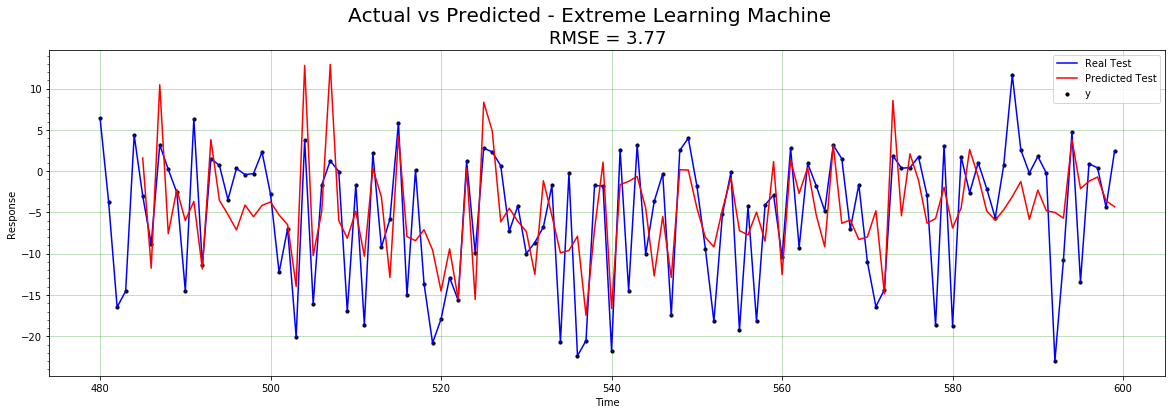

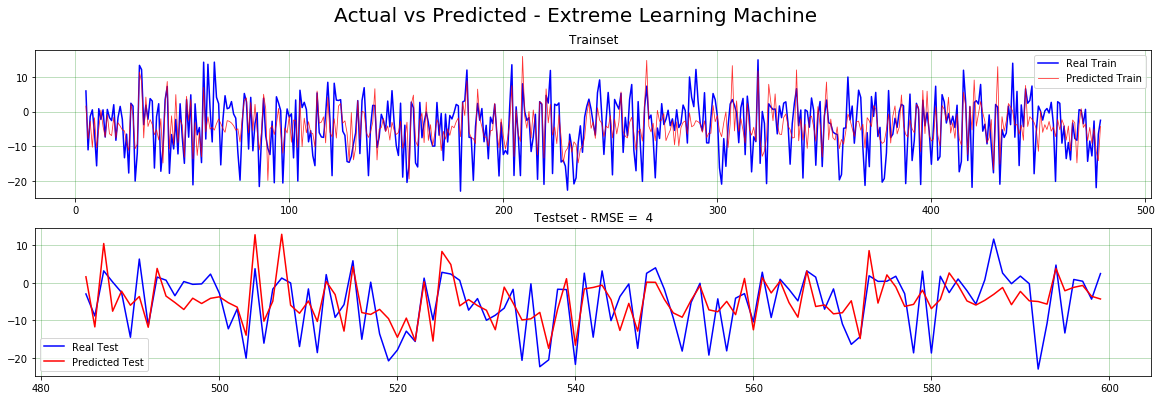

In [10]:
##############################################################################
# TRAIN THE NETWORK AND PREDICT - With previous y
############################################################################## 
in_dim = train_windows_eml_inc.shape[1] - 1
NN = Network(input_dim=in_dim, hidden_dim=20, output_dim=1)
t0 = time.time()
eml_residuals = NN.train(x = train_windows_eml_inc.iloc[:,:-1], 
                     y = train_windows_eml_inc.iloc[:,-1].values.reshape(-1,1))
tF = time.time()


eml_fit_inc = NN.predict(train_windows_eml_inc.iloc[:,:-1])
eml_pred_inc = NN.predict(test_windows_eml_inc.iloc[:,:-1])

eml_residuals_inc = eml_pred_inc - testset.iloc[w:, -1].values.reshape(-1,1)
eml_rmse_inc = np.sqrt(np.sum(np.power(eml_residuals_inc,2)) / len(eml_residuals_inc))
print('RMSE = %.2f' % eml_rmse_inc)
print('Time to train %.2f' % (tF - t0))


eml_y_fit_inc = eml_fit_inc
eml_y_pred_inc = eml_pred_inc


# Plot predictions
f, ax = plt.subplots(1, figsize=(20,6))
plt.suptitle('Actual vs Predicted - Extreme Learning Machine' , fontsize=20)
plt.title('RMSE = %.2f' % eml_rmse, fontsize = 18)
plt.grid(color='green', linewidth=0.5, alpha=0.5)

plt.scatter(testset.index, testset.y, color='black', s=10)
plt.plot(testset.index, testset.y, color='b', label='Real Test')
plt.plot(testset.index[w:], eml_y_pred_inc, color='r', label='Predicted Test')

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xlabel('Time')
plt.ylabel('Response')
plt.legend()
plt.show()


# Complete Plot
f, (ax1, ax2) = plt.subplots(2,1, figsize=(20,6))
plt.suptitle('Actual vs Predicted - Extreme Learning Machine' , fontsize=20)
ax1.grid(color='green', linewidth=0.5, alpha=0.5)
ax2.grid(color='green', linewidth=0.5, alpha=0.5)

ax1.plot(trainset.index[w:], train_windows['y'], color='b', label='Real Train')
ax1.plot(trainset.index[w:], eml_y_fit_inc, color='r', linewidth=0.8, alpha=0.8, label='Predicted Train')
ax1.legend()
ax1.set_title('Trainset')

ax2.plot(testset.index[w:], test_windows['y'], color='b', label='Real Test')
ax2.plot(testset.index[w:], eml_y_pred_inc, color='r', label='Predicted Test')
ax2.set_title('Testset - RMSE = %2.f' % eml_rmse)
ax2.legend()

plt.show()  

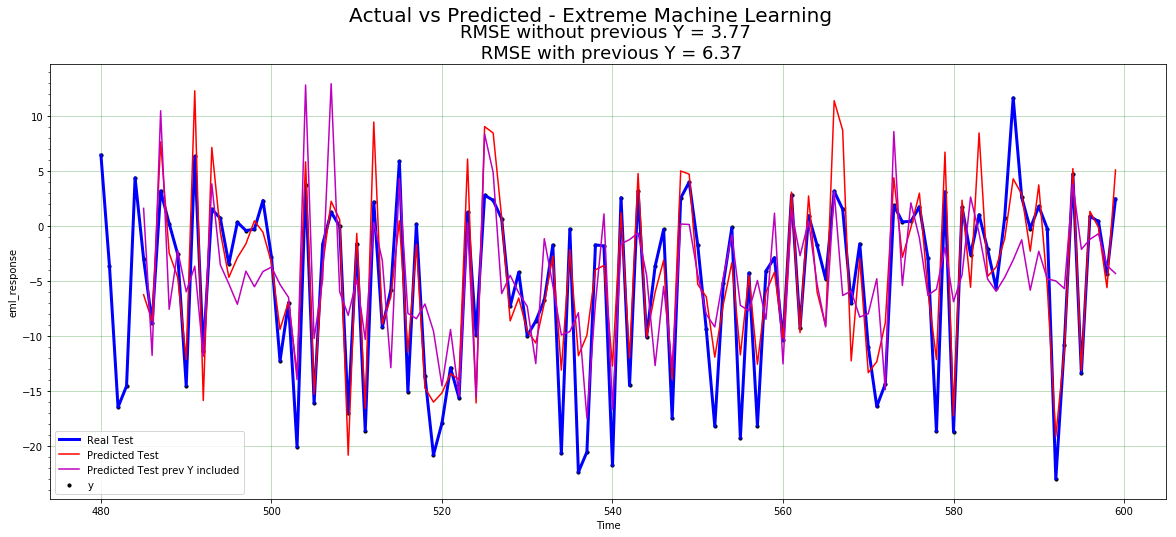

In [14]:
##############################################################################
# COMPARISON
##############################################################################

# Plot Predictions
f, ax = plt.subplots(1, figsize=(20,8))
plt.suptitle('Actual vs Predicted - Extreme Machine Learning' , fontsize=20)
plt.title('RMSE without previous Y = %.2f \n RMSE with previous Y = %.2f' 
          % (eml_rmse, eml_rmse_inc), fontsize = 18)
plt.grid(color='green', linewidth=0.5, alpha=0.5)

plt.scatter(testset.index, testset.y, color='black', s=10)
plt.plot(testset.index, testset.y, color='b', linewidth=3, label='Real Test')
plt.plot(testset.index[w:], eml_y_pred, color='r', linewidth=1.5, label='Predicted Test')
plt.plot(testset.index[w:], eml_y_pred_inc, color='m', linewidth=1.5, label='Predicted Test prev Y included')

ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xlabel('Time')
plt.ylabel('eml_response')
plt.legend()
plt.show()

## Conclusion
---

We can see how EMLs have a great predicting power over our data. Also, it got way worse results where we included previous values of the response as predictors.  

Definitely EMLs are models to keep on exploring, this was a quick implementation that already shows their great power, they were able to compute that accuracy with simple matrix inversion and few more operations.  

#### Online Learning
The absolutely greatest advantage of EMLs is that they are very *cheap* computationally for implementing online models. In [this article]() there is more information about the update and downdate operations. 

In few lines, we could say that the model becomes adaptative, and if the prediction error goes beyond a stablished threshold, this particular data point is incorporated in the SVD so the model does not required an expensive complete retraining. This way the model can adapts and learn from changes that could happen to the process.